## KNN

In [2]:
"""Imports"""
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Carregando o dataset com try e except
try:
    df_walmart = pd.read_csv('data//Walmart.csv')
    print("Dataset 'Walmart.csv' carregado com sucesso!")
    print("\nPrimeiras 5 linhas do dataset:")
    display(df_walmart.head())
    print("\nInformações gerais do dataset antes do pré-processamento:")
    df_walmart.info()
except FileNotFoundError:
    print("Erro: O arquivo 'Walmart.csv' não foi encontrado.")
    print("Por favor, certifique-se de que o arquivo esteja no mesmo diretório do seu script.")

Dataset 'Walmart.csv' carregado com sucesso!

Primeiras 5 linhas do dataset:


,invoice_id,Branch,City,category,unit_price,quantity,date,time,payment_method,rating,profit_margin
0,1,WALM003,San Antonio,Health and beauty,$74.69,7.0,05/01/19,13:08:00,Ewallet,9.1,0.48
1,2,WALM048,Harlingen,Electronic accessories,$15.28,5.0,08/03/19,10:29:00,Cash,9.6,0.48
2,3,WALM067,Haltom City,Home and lifestyle,$46.33,7.0,03/03/19,13:23:00,Credit card,7.4,0.33
3,4,WALM064,Bedford,Health and beauty,$58.22,8.0,27/01/19,20:33:00,Ewallet,8.4,0.33
4,5,WALM013,Irving,Sports and travel,$86.31,7.0,08/02/19,10:37:00,Ewallet,5.3,0.48



Informações gerais do dataset antes do pré-processamento:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10051 entries, 0 to 10050
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   invoice_id      10051 non-null  int64  
 1   Branch          10051 non-null  object 
 2   City            10051 non-null  object 
 3   category        10051 non-null  object 
 4   unit_price      10020 non-null  object 
 5   quantity        10020 non-null  float64
 6   date            10051 non-null  object 
 7   time            10051 non-null  object 
 8   payment_method  10051 non-null  object 
 9   rating          10051 non-null  float64
 10  profit_margin   10051 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 863.9+ KB


In [4]:
""" Pré processamento inicial """

# removendo o '$' e dps converter para float
df_walmart['unit_price'] = df_walmart['unit_price'].astype(str).str.replace('$', '', regex=False).astype(float)

print("\nColuna 'unit_price' convertida para numérico.")
print("Estatísticas descritivas atualizadas para 'unit_price':")
print(df_walmart['unit_price'].describe())


Coluna 'unit_price' convertida para numérico.
Estatísticas descritivas atualizadas para 'unit_price':
count    10020.000000
mean        50.630053
std         21.197783
min         10.080000
25%         32.000000
50%         51.000000
75%         69.000000
max         99.960000
Name: unit_price, dtype: float64


In [5]:
# 3. Criar a variável alvo (y) para Classificação
# nova coluna 'High_Rating' onde 1 significa rating >= 7 e 0 significa rating < 7
df_walmart['High_Rating'] = (df_walmart['rating'] >= 7).astype(int)

print("\nNova coluna 'High_Rating' (variável alvo) criada. Contagem de classes:")
print(df_walmart['High_Rating'].value_counts())



Nova coluna 'High_Rating' (variável alvo) criada. Contagem de classes:
High_Rating
0    6492
1    3559
Name: count, dtype: int64


In [6]:
# 4. Definir características (X) e a variável alvo (y)
# excluí as colunas de identificação, data/hora e as originais 'rating' e 'City' (para evitar redundância com 'Branch' e manter foco)
X = df_walmart.drop(['invoice_id', 'date', 'time', 'rating', 'High_Rating', 'City'], axis=1)
y = df_walmart['High_Rating']

# Identificar colunas numéricas e categóricas para o pré-processamento
numeric_features = ['unit_price', 'quantity', 'profit_margin']
categorical_features = ['category', 'payment_method', 'Branch'] # Estas serão pro One-Hot Encoded

print(f"\nCaracterísticas (X) selecionadas: {numeric_features + categorical_features}")
print(f"Variável alvo (y) selecionada: 'High_Rating'")



Características (X) selecionadas: ['unit_price', 'quantity', 'profit_margin', 'category', 'payment_method', 'Branch']
Variável alvo (y) selecionada: 'High_Rating'


In [7]:
# 5. Tratamento de valores ausentes em X antes do ColumnTransformer
# Para as colunas numéricas, preencher com a média
for col in numeric_features:
    if X[col].isnull().any():
        mean_val = X[col].mean()
        X[col].fillna(mean_val, inplace=True)
        print(f"Valores ausentes na coluna numérica '{col}' preenchidos com a média.")

# Para colunas categóricas, preencher com o modo (valor mais frequente), se houver NaNs
for col in categorical_features:
    if X[col].isnull().any():
        mode_val = X[col].mode()[0] # o 'mode' é pra  retornar múltiplos valores se houver empate
        X[col].fillna(mode_val, inplace=True)
        print(f"Valores ausentes na coluna categórica '{col}' preenchidos com o modo.")


Valores ausentes na coluna numérica 'unit_price' preenchidos com a média.
Valores ausentes na coluna numérica 'quantity' preenchidos com a média.


C:\Users\Rafael\AppData\Local\Temp\ipykernel_16012\1667778973.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(mean_val, inplace=True)


In [8]:
# 6. Criar um pré-processador usando ColumnTransformer e Pipeline
# Standardscaler --> colunas numéricas
# OneHotEncoder --> colunas categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [9]:
# 7. Dividir os dados em conjuntos de treinamento e teste
# test_size=0.3  30% dos dados serão usados pra teste
# random_state=42 é só pra garantir que a divisão seja sempre a mesma em execuções diferentes
# stratify=y é pra garantir que a proporção das classes de 'High_Rating' seja mantida nos conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"\nDados divididos: Treino={len(X_train)} amostras, Teste={len(X_test)} amostras.")
print(f"Proporção de 'High_Rating' no treino:\n{y_train.value_counts(normalize=True)}")
print(f"Proporção de 'High_Rating' no teste:\n{y_test.value_counts(normalize=True)}")



Dados divididos: Treino=7035 amostras, Teste=3016 amostras.
Proporção de 'High_Rating' no treino:
High_Rating
0    0.645913
1    0.354087
Name: proportion, dtype: float64
Proporção de 'High_Rating' no teste:
High_Rating
0    0.645889
1    0.354111
Name: proportion, dtype: float64


In [10]:
# 8. Treinar e avaliar o modelo KNN
# criando pipeline que primeiro pré-processa os dados e depois aplica o classificador KNN
# n_neighbors: número de vizinhos mais próximos a considerar = 5 pra começar
knn_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', KNeighborsClassifier(n_neighbors=5))])

print("\nTreinando o modelo KNN...")
knn_pipeline.fit(X_train, y_train)
print("Treinamento do KNN concluído.")

# Fazer previsões no conjunto de teste
y_pred_knn = knn_pipeline.predict(X_test)

# Avaliar o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred_knn)
print(f"\n--- Resultados do KNN ---")
print(f"Acurácia do KNN no conjunto de teste: {accuracy:.4f}")

print("\nRelatório de Classificação (Precision, Recall, F1-score):")
print(classification_report(y_test, y_pred_knn, target_names=['Baixa Avaliação (0)', 'Alta Avaliação (1)']))

print("\nMatriz de Confusão:")
cm = confusion_matrix(y_test, y_pred_knn)
print(cm)


Treinando o modelo KNN...
Treinamento do KNN concluído.

--- Resultados do KNN ---
Acurácia do KNN no conjunto de teste: 0.6144

Relatório de Classificação (Precision, Recall, F1-score):
                     precision    recall  f1-score   support

Baixa Avaliação (0)       0.68      0.77      0.72      1948
 Alta Avaliação (1)       0.44      0.33      0.37      1068

           accuracy                           0.61      3016
          macro avg       0.56      0.55      0.55      3016
       weighted avg       0.59      0.61      0.60      3016


Matriz de Confusão:
[[1505  443]
 [ 720  348]]


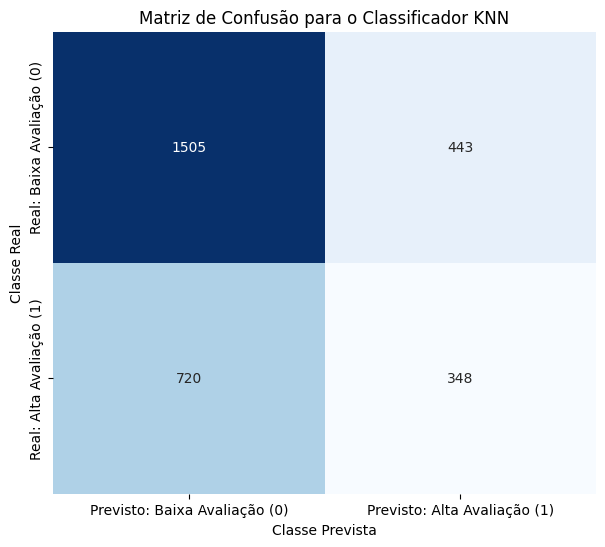


--- Exemplo de Nova Previsão com KNN ---


In [11]:
# 9. Visualização da Matriz de Confusão
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Previsto: Baixa Avaliação (0)', 'Previsto: Alta Avaliação (1)'],yticklabels=['Real: Baixa Avaliação (0)', 'Real: Alta Avaliação (1)'])
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.title('Matriz de Confusão para o Classificador KNN')
plt.show()


# Exemplo de uma nova previsão:
print("\n--- Exemplo de Nova Previsão com KNN ---")
# Criar um novo ponto de dados (com valores hipotéticos)
new_data = pd.DataFrame({
    'unit_price': [55.0],
    'quantity': [4.0],
    'profit_margin': [0.4],
    'category': ['Food and beverages'], # Certifique-se de que a categoria exista nos dados de treino ou use 'handle_unknown='ignore'
    'payment_method': ['Credit card'],
    'Branch': ['A']
})

In [12]:
# Fazer a previsão usando o pipeline treinado
new_prediction = knn_pipeline.predict(new_data)
predicted_class = 'Alta Avaliação' if new_prediction[0] == 1 else 'Baixa Avaliação'
print(f"O modelo KNN previu que esta transação terá uma: {predicted_class}")

O modelo KNN previu que esta transação terá uma: Baixa Avaliação


In [13]:
print("--- Exemplo de uso do modelo ---")

novo_dado_transacao = pd.DataFrame({
    'unit_price': [70.50],           #  preço unitário hipotético
    'quantity': [2.0],               # Duas unidades compradas
    'profit_margin': [0.45],         # Margem de lucro de 45%
    'category': ['Home and lifestyle'], # Categoria do produto
    'payment_method': ['Cash'],      # Método de pagamento
    'Branch': ['B']                  # Filial da transação
})

print("\nNovo dado de transação para previsão:")
display(novo_dado_transacao)


previsao_bruta = knn_pipeline.predict(novo_dado_transacao)

# lembrando que o modelo retorna 1 para 'Alta Avaliação' e 0 para 'Baixa Avaliação'
resultado_legivel = 'Alta Avaliação' if previsao_bruta[0] == 1 else 'Baixa Avaliação'

print(f"\nO modelo KNN previu que esta transação terá uma: {resultado_legivel}")

--- Exemplo de uso do modelo ---

Novo dado de transação para previsão:


,unit_price,quantity,profit_margin,category,payment_method,Branch
0,70.5,2.0,0.45,Home and lifestyle,Cash,B



O modelo KNN previu que esta transação terá uma: Baixa Avaliação
